## Time Series Forecasting with Recurrent Neural Network (RNN)

by Haydar Özler and Tankut Tekeli

### Abstract

* Purpose: to practice solving a timeseries problem by using Recurrent Neural Network

* Data: Bike Sharing in Washington D.C. Dataset

* Applied Tools & Methods: TimeSeriesGenerator, SimpleRNN

* Result: Around %80 correctness (calculated as 1-mae/mean)

* Further Studies: More advanced sequential methods like LSTM and GRU can be applied.

### Explanation of the Study

We have created a model to predict how many bicycles will be rented in the following days. The features used like weather, temperature, working day are explained in the following sections in detail. 

We have used SimpleRNN method in Keras library. It is one of the sequential models. The others are LSTM and GRU. 

Sequential models have 3 dimension (sample size, time steps, features). Preparing 3D input is another challenge. Instead of trying to create a 3D array, we use TimeSeriesGenerator class which brings some other advantages like setting the batch size.

We skipped feature engineering and visualization parts because main purpose was to practice a sequential neural network. It is possible to have better achivements by applying these methods and then create a predictive model. 

Data is 2 years daily data. Number of samples is 731. We have splitted it into 631, 50, 50 as train, test and hold-out data respectively.

We have measured the performance of the model with ( 1 - (mean average error) / (mean) ) and we have reached values around %80.

There are so many further studies: More feature engineering for better accuracy and trying other sequential models. 

### Importing Libraries

In [1]:
import pandas as pd;
import matplotlib.pyplot as plt
from numpy import array
from numpy import hstack
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import RNN, SimpleRNN
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.layers import Dropout
from keras.optimizers import Adam
from keras.layers.core import Activation
from keras.callbacks import LambdaCallback
from sklearn.preprocessing import MinMaxScaler

C:\Users\ho46888\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Data Preprocessing

#### Reading the dataset

In [2]:
dataset = pd.read_csv('day.csv')

In [3]:
dataset.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


Daily data has the following fields. Thanks to the people who prepared it because it is very well processed data with even scaled features. 

instant: Record index

dteday: Date

season: Season (1:springer, 2:summer, 3:fall, 4:winter)

yr: Year (0: 2011, 1:2012)

mnth: Month (1 to 12)

holiday: weather day is holiday or not (extracted from Holiday Schedule)

weekday: Day of the week

workingday: If day is neither weekend nor holiday is 1, otherwise is 0.

weathersit: (extracted from Freemeteo)
1: Clear, Few clouds, Partly cloudy, Partly cloudy
2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog

temp: Normalized temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-8, t_max=+39 (only in hourly scale)

atemp: Normalized feeling temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-16, t_max=+50 (only in hourly scale)

hum: Normalized humidity. The values are divided to 100 (max)

windspeed: Normalized wind speed. The values are divided to 67 (max)

casual: count of casual users

registered: count of registered users

cnt: count of total rental bikes including both casual and registered

#### Plot of 2 years number of sharing (cnt)

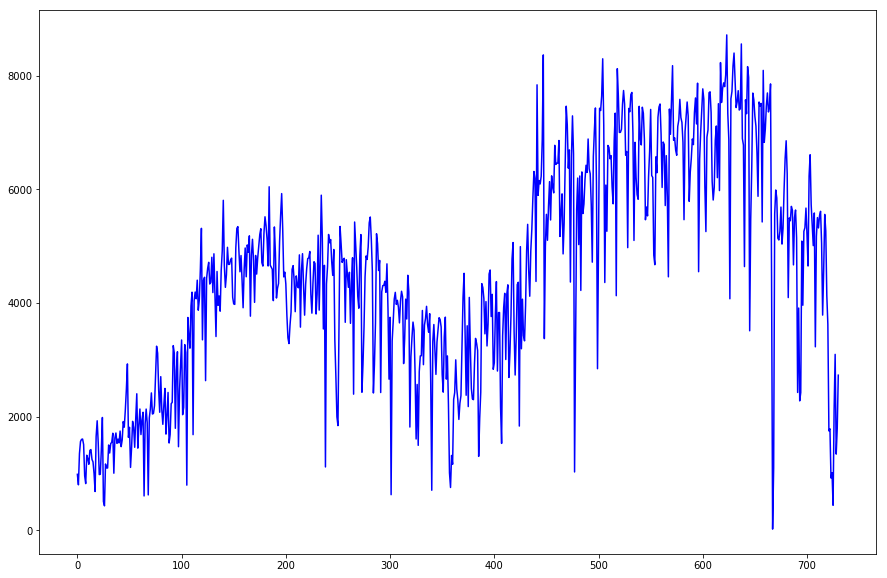

In [4]:
plt.figure(figsize=(15,10))
plt.plot(dataset['cnt'], color='blue')
plt.show()

#### Data exploration and Manipulation

* Number of bike sharing is 22 only at 2012-10-29 and such a low value deserves a special attention.

* There was a hurricane at Washington at that day.

* Since it is such an extraordinary day, hurricane and the following days data will be replaced by the average of that month.

In [5]:
temp = dataset[dataset.yr == 1]
temp = temp[temp.mnth == 10]
print(temp.cnt.mean())

6414.225806451613


In [6]:
temp.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
639,640,2012-10-01,4,1,10,0,1,1,2,0.520833,0.512000,0.649167,0.090804,763,6015,6778
640,641,2012-10-02,4,1,10,0,2,1,3,0.590833,0.542333,0.871667,0.104475,315,4324,4639
641,642,2012-10-03,4,1,10,0,3,1,2,0.657500,0.599133,0.793750,0.066546,728,6844,7572
642,643,2012-10-04,4,1,10,0,4,1,2,0.657500,0.607975,0.722917,0.117546,891,6437,7328
643,644,2012-10-05,4,1,10,0,5,1,1,0.615000,0.580187,0.627500,0.106350,1516,6640,8156


In [7]:
print(dataset['cnt'][667], dataset['cnt'][668])

22 1096


In [8]:
dataset['cnt'][667] = 6414
dataset['cnt'][668] = 6414

C:\Users\ho46888\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\ho46888\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


#### One Hot Encoding

We should apply one hot encoding for categorical features. In our case weekday, weathersit and mnth features are one hot encoded.

In [9]:
one_hot = pd.get_dummies(dataset['weekday'], prefix='weekday')
dataset = dataset.join(one_hot)

In [10]:
one_hot = pd.get_dummies(dataset['weathersit'], prefix='weathersit')
dataset = dataset.join(one_hot)

In [11]:
one_hot = pd.get_dummies(dataset['mnth'], prefix='mnth')
dataset = dataset.join(one_hot)

#### Scaling

Thanks to the guys prepared the original data, they scaled all features. That is why we have to apply it only for our value Y which is cnt. It is also a discussion whether Y value should be scaled or not in sucha model but we did. 

In [12]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(array(dataset['cnt']).reshape(len(dataset['cnt']), 1))
series = pd.DataFrame(scaled)
series.columns = ['cntscl']

C:\Users\ho46888\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [13]:
dataset = pd.merge(dataset, series, left_index=True, right_index=True)

In [14]:
dataset.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,...,mnth_4,mnth_5,mnth_6,mnth_7,mnth_8,mnth_9,mnth_10,mnth_11,mnth_12,cntscl
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,...,0,0,0,0,0,0,0,0,0,0.066884
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,...,0,0,0,0,0,0,0,0,0,0.044670
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,...,0,0,0,0,0,0,0,0,0,0.110829
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,...,0,0,0,0,0,0,0,0,0,0.136545
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,...,0,0,0,0,0,0,0,0,0,0.141132


#### Data Splitting

In [15]:
number_of_test_data = 50
number_of_holdout_data = 50
number_of_training_data = len(dataset) - number_of_holdout_data - number_of_test_data
print ("total, train, test, holdout:", len(dataset), number_of_training_data, number_of_test_data, number_of_holdout_data)

total, train, test, holdout: 731 631 50 50


In [16]:
datatrain = dataset[:number_of_training_data]
datatest = dataset[-(number_of_test_data+number_of_holdout_data):-number_of_holdout_data]
datahold = dataset[-number_of_holdout_data:]

### Preparing 3-Dimensional Input for Sequential Model

The following steps show the way how to prepare input for a sequential model by using TimeSeriesGenerator.

In [17]:
in_seq1 = array(datatrain['holiday'])
in_seq2 = array(datatrain['workingday'])
in_seq3 = array(datatrain['temp'])
in_seq4 = array(datatrain['atemp'])
in_seq5 = array(datatrain['hum'])
in_seq6 = array(datatrain['windspeed'])
in_seq7 = array(datatrain['weekday_0'])
in_seq8 = array(datatrain['weekday_1'])
in_seq9 = array(datatrain['weekday_2'])
in_seq10 = array(datatrain['weekday_3'])
in_seq11 = array(datatrain['weekday_4'])
in_seq12 = array(datatrain['weekday_5'])
in_seq13 = array(datatrain['weekday_6'])
in_seq14 = array(datatrain['weathersit_1'])
in_seq15 = array(datatrain['weathersit_2'])
in_seq16 = array(datatrain['weathersit_3'])
out_seq_train = array(datatrain['cntscl'])

In [18]:
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
in_seq3 = in_seq3.reshape((len(in_seq3), 1))
in_seq4 = in_seq4.reshape((len(in_seq4), 1))
in_seq5 = in_seq5.reshape((len(in_seq5), 1))
in_seq6 = in_seq6.reshape((len(in_seq6), 1))
in_seq7 = in_seq7.reshape((len(in_seq7), 1))
in_seq8 = in_seq8.reshape((len(in_seq8), 1))
in_seq9 = in_seq9.reshape((len(in_seq9), 1))
in_seq10 = in_seq10.reshape((len(in_seq10), 1))
in_seq11 = in_seq11.reshape((len(in_seq11), 1))
in_seq12 = in_seq12.reshape((len(in_seq12), 1))
in_seq13 = in_seq13.reshape((len(in_seq13), 1))
in_seq14 = in_seq14.reshape((len(in_seq14), 1))
in_seq15 = in_seq15.reshape((len(in_seq15), 1))
in_seq16 = in_seq16.reshape((len(in_seq16), 1))
out_seq_train = out_seq_train.reshape((len(out_seq_train), 1))

In [19]:
datatrain_feed = hstack((in_seq1, in_seq2, in_seq3, in_seq4, in_seq5, in_seq6, in_seq7, in_seq8, in_seq9, in_seq10, in_seq11, in_seq12, in_seq13, in_seq14, in_seq15, in_seq16, out_seq_train))

In [20]:
in_seq1 = array(datatest['holiday'])
in_seq2 = array(datatest['workingday'])
in_seq3 = array(datatest['temp'])
in_seq4 = array(datatest['atemp'])
in_seq5 = array(datatest['hum'])
in_seq6 = array(datatest['windspeed'])
in_seq7 = array(datatest['weekday_0'])
in_seq8 = array(datatest['weekday_1'])
in_seq9 = array(datatest['weekday_2'])
in_seq10 = array(datatest['weekday_3'])
in_seq11 = array(datatest['weekday_4'])
in_seq12 = array(datatest['weekday_5'])
in_seq13 = array(datatest['weekday_6'])
in_seq14 = array(datatest['weathersit_1'])
in_seq15 = array(datatest['weathersit_2'])
in_seq16 = array(datatest['weathersit_3'])
out_seq_test = array(datatest['cntscl'])

In [21]:
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
in_seq3 = in_seq3.reshape((len(in_seq3), 1))
in_seq4 = in_seq4.reshape((len(in_seq4), 1))
in_seq5 = in_seq5.reshape((len(in_seq5), 1))
in_seq6 = in_seq6.reshape((len(in_seq6), 1))
in_seq7 = in_seq7.reshape((len(in_seq7), 1))
in_seq8 = in_seq8.reshape((len(in_seq8), 1))
in_seq9 = in_seq9.reshape((len(in_seq9), 1))
in_seq10 = in_seq10.reshape((len(in_seq10), 1))
in_seq11 = in_seq11.reshape((len(in_seq11), 1))
in_seq12 = in_seq12.reshape((len(in_seq12), 1))
in_seq13 = in_seq13.reshape((len(in_seq13), 1))
in_seq14 = in_seq14.reshape((len(in_seq14), 1))
in_seq15 = in_seq15.reshape((len(in_seq15), 1))
in_seq16 = in_seq16.reshape((len(in_seq16), 1))
out_seq_test = out_seq_test.reshape((len(out_seq_test), 1))

In [22]:
datatest_feed = hstack((in_seq1, in_seq2, in_seq3, in_seq4, in_seq5, in_seq6, in_seq7, in_seq8, in_seq9, in_seq10, in_seq11, in_seq12, in_seq13, in_seq14, in_seq15, in_seq16, out_seq_test))

In [23]:
in_seq1 = array(datahold['holiday'])
in_seq2 = array(datahold['workingday'])
in_seq3 = array(datahold['temp'])
in_seq4 = array(datahold['atemp'])
in_seq5 = array(datahold['hum'])
in_seq6 = array(datahold['windspeed'])
in_seq7 = array(datahold['weekday_0'])
in_seq8 = array(datahold['weekday_1'])
in_seq9 = array(datahold['weekday_2'])
in_seq10 = array(datahold['weekday_3'])
in_seq11 = array(datahold['weekday_4'])
in_seq12 = array(datahold['weekday_5'])
in_seq13 = array(datahold['weekday_6'])
in_seq14 = array(datahold['weathersit_1'])
in_seq15 = array(datahold['weathersit_2'])
in_seq16 = array(datahold['weathersit_3'])
out_seq_hold = array(datahold['cntscl'])

In [24]:
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
in_seq3 = in_seq3.reshape((len(in_seq3), 1))
in_seq4 = in_seq4.reshape((len(in_seq4), 1))
in_seq5 = in_seq5.reshape((len(in_seq5), 1))
in_seq6 = in_seq6.reshape((len(in_seq6), 1))
in_seq7 = in_seq7.reshape((len(in_seq7), 1))
in_seq8 = in_seq8.reshape((len(in_seq8), 1))
in_seq9 = in_seq9.reshape((len(in_seq9), 1))
in_seq10 = in_seq10.reshape((len(in_seq10), 1))
in_seq11 = in_seq11.reshape((len(in_seq11), 1))
in_seq12 = in_seq12.reshape((len(in_seq12), 1))
in_seq13 = in_seq13.reshape((len(in_seq13), 1))
in_seq14 = in_seq14.reshape((len(in_seq14), 1))
in_seq15 = in_seq15.reshape((len(in_seq15), 1))
in_seq16 = in_seq16.reshape((len(in_seq16), 1))
out_seq_hold = out_seq_hold.reshape((len(out_seq_hold), 1))

In [25]:
datahold_feed = hstack((in_seq1, in_seq2, in_seq3, in_seq4, in_seq5, in_seq6, in_seq7, in_seq8, in_seq9, in_seq10, in_seq11, in_seq12, in_seq13, in_seq14, in_seq15, in_seq16, out_seq_hold))

In [26]:
n_features = datatrain_feed.shape[1]
n_input = 10
generator_train = TimeseriesGenerator(datatrain_feed, out_seq_train, length=n_input, batch_size=len(datatrain_feed))

In [27]:
for i in range(len(generator_train)):
	x, y = generator_train[i]
	print('%s => %s' % (x, y))

[[[0.         0.         0.344167   ... 1.         0.         0.06688398]
  [0.         0.         0.363478   ... 1.         0.         0.04466981]
  [0.         1.         0.196364   ... 0.         0.         0.11082941]
  ...
  [0.         0.         0.165      ... 1.         0.         0.06374502]
  [0.         0.         0.138333   ... 0.         0.         0.04720512]
  [0.         1.         0.150833   ... 0.         0.         0.10744899]]

 [[0.         0.         0.363478   ... 1.         0.         0.04466981]
  [0.         1.         0.196364   ... 0.         0.         0.11082941]
  [0.         1.         0.2        ... 0.         0.         0.13654473]
  ...
  [0.         0.         0.138333   ... 0.         0.         0.04720512]
  [0.         1.         0.150833   ... 0.         0.         0.10744899]
  [0.         1.         0.169091   ... 1.         0.         0.1004467 ]]

 [[0.         1.         0.196364   ... 0.         0.         0.11082941]
  [0.         1.      

In [28]:
generator_test = TimeseriesGenerator(datatest_feed, out_seq_test, length=n_input, batch_size=1)

In [29]:
for i in range(len(generator_test)):
	x, y = generator_test[i]
	print('%s => %s' % (x, y))

[[[0.         0.         0.529167   0.518933   0.467083   0.223258
   1.         0.         0.         0.         0.         0.
   0.         1.         0.         0.         0.90257153]
  [0.         1.         0.514167   0.502513   0.492917   0.142404
   0.         1.         0.         0.         0.         0.
   0.         1.         0.         0.         0.84570808]
  [0.         1.         0.55       0.544179   0.57       0.236321
   0.         0.         1.         0.         0.         0.
   0.         1.         0.         0.         0.85802246]
  [0.         1.         0.635      0.596613   0.630833   0.2444
   0.         0.         0.         1.         0.         0.
   0.         1.         0.         0.         0.88156465]
  [0.         1.         0.65       0.607975   0.690833   0.134342
   0.         0.         0.         0.         1.         0.
   0.         0.         1.         0.         0.84051672]
  [0.         1.         0.619167   0.585863   0.69       0.164179


In [30]:
generator_hold = TimeseriesGenerator(datahold_feed, out_seq_hold, length=n_input, batch_size=1)

In [31]:
for i in range(len(generator_hold)):
	x, y = generator_hold[i]
	print('%s => %s' % (x, y))

[[[1.         0.         0.485      0.475383   0.741667   0.173517
   0.         1.         0.         0.         0.         0.
   0.         1.         0.         0.         0.7048171 ]
  [0.         1.         0.343333   0.323225   0.662917   0.342046
   0.         0.         1.         0.         0.         0.
   0.         0.         1.         0.         0.44223108]
  [0.         1.         0.289167   0.281563   0.552083   0.199625
   0.         0.         0.         1.         0.         0.
   0.         1.         0.         0.         0.61137269]
  [0.         1.         0.321667   0.324492   0.620417   0.152987
   0.         0.         0.         0.         1.         0.
   0.         0.         1.         0.         0.60533623]
  [0.         1.         0.345      0.347204   0.524583   0.171025
   0.         0.         0.         0.         0.         1.
   0.         1.         0.         0.         0.63588072]
  [0.         0.         0.325      0.326383   0.545417   0.17972

[[[0.         0.         0.245833   0.257583   0.468333   0.1505
   1.         0.         0.         0.         0.         0.
   0.         1.         0.         0.         0.2406133 ]
  [0.         1.         0.313333   0.339004   0.535417   0.04665
   0.         1.         0.         0.         0.         0.
   0.         1.         0.         0.         0.56211518]
  [0.         1.         0.291667   0.281558   0.786667   0.237562
   0.         0.         1.         0.         0.         0.
   0.         0.         1.         0.         0.42593263]
  [0.         1.         0.296667   0.289762   0.50625    0.210821
   0.         0.         0.         1.         0.         0.
   0.         1.         0.         0.         0.58300133]
  [0.         1.         0.28087    0.298422   0.555652   0.115522
   0.         0.         0.         0.         1.         0.
   0.         1.         0.         0.         0.59060727]
  [0.         1.         0.298333   0.323867   0.649583   0.0584708


### Modelling and Training

We have created a small RNN with 4 nodes. 
Number of total parameters in the model is 93. 
Number of timesteps in one batch is 10. 
Activation function is relu both for RNN and Output layer.
Optimizer is adam.
Loss function is mean squared error.
Learning rate is 0.0001.
Number of epocs is 3,000.

#### Creating the SimpleRNN Model

In [32]:
print("timesteps, features:", n_input, n_features)

timesteps, features: 10 17


In [54]:
model = Sequential()

model.add(SimpleRNN(4, activation='relu', input_shape=(n_input, n_features), return_sequences = False))
model.add(Dense(1, activation='relu'))

adam = Adam(lr=0.0001)
model.compile(optimizer=adam, loss='mse')

In [55]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_4 (SimpleRNN)     (None, 4)                 88        
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 5         
Total params: 93
Trainable params: 93
Non-trainable params: 0
_________________________________________________________________


#### Training the Model

In [56]:
score = model.fit_generator(generator_train, epochs=3000, verbose=2, validation_data=generator_test)

Epoch 1/3000
 - 1s - loss: 0.2159 - val_loss: 0.4273
Epoch 2/3000
 - 0s - loss: 0.2156 - val_loss: 0.4269
Epoch 3/3000
 - 0s - loss: 0.2154 - val_loss: 0.4265
Epoch 4/3000
 - 0s - loss: 0.2152 - val_loss: 0.4261
Epoch 5/3000
 - 0s - loss: 0.2149 - val_loss: 0.4257
Epoch 6/3000
 - 0s - loss: 0.2147 - val_loss: 0.4253
Epoch 7/3000
 - 0s - loss: 0.2144 - val_loss: 0.4248
Epoch 8/3000
 - 0s - loss: 0.2142 - val_loss: 0.4244
Epoch 9/3000
 - 0s - loss: 0.2139 - val_loss: 0.4240
Epoch 10/3000
 - 0s - loss: 0.2137 - val_loss: 0.4236
Epoch 11/3000
 - 0s - loss: 0.2134 - val_loss: 0.4232
Epoch 12/3000
 - 0s - loss: 0.2132 - val_loss: 0.4228
Epoch 13/3000
 - 0s - loss: 0.2129 - val_loss: 0.4224
Epoch 14/3000
 - 0s - loss: 0.2127 - val_loss: 0.4219
Epoch 15/3000
 - 0s - loss: 0.2124 - val_loss: 0.4215
Epoch 16/3000
 - 0s - loss: 0.2122 - val_loss: 0.4211
Epoch 17/3000
 - 0s - loss: 0.2119 - val_loss: 0.4207
Epoch 18/3000
 - 0s - loss: 0.2117 - val_loss: 0.4203
Epoch 19/3000
 - 0s - loss: 0.2115 - 

Epoch 152/3000
 - 0s - loss: 0.1748 - val_loss: 0.3674
Epoch 153/3000
 - 0s - loss: 0.1745 - val_loss: 0.3668
Epoch 154/3000
 - 0s - loss: 0.1742 - val_loss: 0.3662
Epoch 155/3000
 - 0s - loss: 0.1738 - val_loss: 0.3656
Epoch 156/3000
 - 0s - loss: 0.1735 - val_loss: 0.3650
Epoch 157/3000
 - 0s - loss: 0.1732 - val_loss: 0.3645
Epoch 158/3000
 - 0s - loss: 0.1729 - val_loss: 0.3639
Epoch 159/3000
 - 0s - loss: 0.1725 - val_loss: 0.3633
Epoch 160/3000
 - 0s - loss: 0.1722 - val_loss: 0.3627
Epoch 161/3000
 - 0s - loss: 0.1719 - val_loss: 0.3622
Epoch 162/3000
 - 0s - loss: 0.1716 - val_loss: 0.3616
Epoch 163/3000
 - 0s - loss: 0.1712 - val_loss: 0.3610
Epoch 164/3000
 - 0s - loss: 0.1709 - val_loss: 0.3605
Epoch 165/3000
 - 0s - loss: 0.1706 - val_loss: 0.3599
Epoch 166/3000
 - 0s - loss: 0.1703 - val_loss: 0.3594
Epoch 167/3000
 - 0s - loss: 0.1700 - val_loss: 0.3588
Epoch 168/3000
 - 0s - loss: 0.1696 - val_loss: 0.3583
Epoch 169/3000
 - 0s - loss: 0.1693 - val_loss: 0.3578
Epoch 170/

Epoch 301/3000
 - 0s - loss: 0.1303 - val_loss: 0.2991
Epoch 302/3000
 - 0s - loss: 0.1301 - val_loss: 0.2986
Epoch 303/3000
 - 0s - loss: 0.1298 - val_loss: 0.2981
Epoch 304/3000
 - 0s - loss: 0.1296 - val_loss: 0.2977
Epoch 305/3000
 - 0s - loss: 0.1294 - val_loss: 0.2972
Epoch 306/3000
 - 0s - loss: 0.1291 - val_loss: 0.2967
Epoch 307/3000
 - 0s - loss: 0.1289 - val_loss: 0.2962
Epoch 308/3000
 - 0s - loss: 0.1287 - val_loss: 0.2957
Epoch 309/3000
 - 0s - loss: 0.1285 - val_loss: 0.2953
Epoch 310/3000
 - 0s - loss: 0.1282 - val_loss: 0.2948
Epoch 311/3000
 - 0s - loss: 0.1280 - val_loss: 0.2943
Epoch 312/3000
 - 0s - loss: 0.1278 - val_loss: 0.2938
Epoch 313/3000
 - 0s - loss: 0.1275 - val_loss: 0.2933
Epoch 314/3000
 - 0s - loss: 0.1273 - val_loss: 0.2929
Epoch 315/3000
 - 0s - loss: 0.1271 - val_loss: 0.2924
Epoch 316/3000
 - 0s - loss: 0.1269 - val_loss: 0.2919
Epoch 317/3000
 - 0s - loss: 0.1267 - val_loss: 0.2915
Epoch 318/3000
 - 0s - loss: 0.1264 - val_loss: 0.2910
Epoch 319/

Epoch 450/3000
 - 0s - loss: 0.1034 - val_loss: 0.2461
Epoch 451/3000
 - 0s - loss: 0.1033 - val_loss: 0.2459
Epoch 452/3000
 - 0s - loss: 0.1031 - val_loss: 0.2457
Epoch 453/3000
 - 0s - loss: 0.1030 - val_loss: 0.2454
Epoch 454/3000
 - 0s - loss: 0.1029 - val_loss: 0.2452
Epoch 455/3000
 - 0s - loss: 0.1027 - val_loss: 0.2450
Epoch 456/3000
 - 0s - loss: 0.1026 - val_loss: 0.2447
Epoch 457/3000
 - 0s - loss: 0.1025 - val_loss: 0.2445
Epoch 458/3000
 - 0s - loss: 0.1024 - val_loss: 0.2443
Epoch 459/3000
 - 0s - loss: 0.1022 - val_loss: 0.2441
Epoch 460/3000
 - 0s - loss: 0.1021 - val_loss: 0.2439
Epoch 461/3000
 - 0s - loss: 0.1020 - val_loss: 0.2437
Epoch 462/3000
 - 0s - loss: 0.1018 - val_loss: 0.2435
Epoch 463/3000
 - 0s - loss: 0.1017 - val_loss: 0.2433
Epoch 464/3000
 - 0s - loss: 0.1016 - val_loss: 0.2431
Epoch 465/3000
 - 0s - loss: 0.1015 - val_loss: 0.2429
Epoch 466/3000
 - 0s - loss: 0.1013 - val_loss: 0.2427
Epoch 467/3000
 - 0s - loss: 0.1012 - val_loss: 0.2425
Epoch 468/

Epoch 599/3000
 - 0s - loss: 0.0875 - val_loss: 0.2247
Epoch 600/3000
 - 0s - loss: 0.0874 - val_loss: 0.2245
Epoch 601/3000
 - 0s - loss: 0.0873 - val_loss: 0.2244
Epoch 602/3000
 - 0s - loss: 0.0872 - val_loss: 0.2242
Epoch 603/3000
 - 0s - loss: 0.0871 - val_loss: 0.2241
Epoch 604/3000
 - 0s - loss: 0.0870 - val_loss: 0.2239
Epoch 605/3000
 - 0s - loss: 0.0869 - val_loss: 0.2237
Epoch 606/3000
 - 0s - loss: 0.0868 - val_loss: 0.2236
Epoch 607/3000
 - 0s - loss: 0.0867 - val_loss: 0.2234
Epoch 608/3000
 - 0s - loss: 0.0866 - val_loss: 0.2233
Epoch 609/3000
 - 0s - loss: 0.0865 - val_loss: 0.2231
Epoch 610/3000
 - 0s - loss: 0.0865 - val_loss: 0.2229
Epoch 611/3000
 - 0s - loss: 0.0864 - val_loss: 0.2228
Epoch 612/3000
 - 0s - loss: 0.0863 - val_loss: 0.2226
Epoch 613/3000
 - 0s - loss: 0.0862 - val_loss: 0.2225
Epoch 614/3000
 - 0s - loss: 0.0861 - val_loss: 0.2223
Epoch 615/3000
 - 0s - loss: 0.0860 - val_loss: 0.2222
Epoch 616/3000
 - 0s - loss: 0.0859 - val_loss: 0.2220
Epoch 617/

Epoch 748/3000
 - 0s - loss: 0.0745 - val_loss: 0.1997
Epoch 749/3000
 - 0s - loss: 0.0744 - val_loss: 0.1995
Epoch 750/3000
 - 0s - loss: 0.0743 - val_loss: 0.1993
Epoch 751/3000
 - 0s - loss: 0.0743 - val_loss: 0.1992
Epoch 752/3000
 - 0s - loss: 0.0742 - val_loss: 0.1990
Epoch 753/3000
 - 0s - loss: 0.0741 - val_loss: 0.1988
Epoch 754/3000
 - 0s - loss: 0.0740 - val_loss: 0.1986
Epoch 755/3000
 - 0s - loss: 0.0739 - val_loss: 0.1984
Epoch 756/3000
 - 0s - loss: 0.0739 - val_loss: 0.1982
Epoch 757/3000
 - 0s - loss: 0.0738 - val_loss: 0.1981
Epoch 758/3000
 - 0s - loss: 0.0737 - val_loss: 0.1979
Epoch 759/3000
 - 0s - loss: 0.0736 - val_loss: 0.1977
Epoch 760/3000
 - 0s - loss: 0.0735 - val_loss: 0.1975
Epoch 761/3000
 - 0s - loss: 0.0735 - val_loss: 0.1973
Epoch 762/3000
 - 0s - loss: 0.0734 - val_loss: 0.1971
Epoch 763/3000
 - 0s - loss: 0.0733 - val_loss: 0.1969
Epoch 764/3000
 - 0s - loss: 0.0732 - val_loss: 0.1967
Epoch 765/3000
 - 0s - loss: 0.0731 - val_loss: 0.1965
Epoch 766/

Epoch 897/3000
 - 0s - loss: 0.0641 - val_loss: 0.1770
Epoch 898/3000
 - 0s - loss: 0.0641 - val_loss: 0.1768
Epoch 899/3000
 - 0s - loss: 0.0640 - val_loss: 0.1767
Epoch 900/3000
 - 0s - loss: 0.0639 - val_loss: 0.1765
Epoch 901/3000
 - 0s - loss: 0.0639 - val_loss: 0.1763
Epoch 902/3000
 - 0s - loss: 0.0638 - val_loss: 0.1762
Epoch 903/3000
 - 0s - loss: 0.0638 - val_loss: 0.1760
Epoch 904/3000
 - 0s - loss: 0.0637 - val_loss: 0.1759
Epoch 905/3000
 - 0s - loss: 0.0637 - val_loss: 0.1757
Epoch 906/3000
 - 0s - loss: 0.0636 - val_loss: 0.1755
Epoch 907/3000
 - 0s - loss: 0.0635 - val_loss: 0.1754
Epoch 908/3000
 - 0s - loss: 0.0635 - val_loss: 0.1752
Epoch 909/3000
 - 0s - loss: 0.0634 - val_loss: 0.1751
Epoch 910/3000
 - 0s - loss: 0.0634 - val_loss: 0.1749
Epoch 911/3000
 - 0s - loss: 0.0633 - val_loss: 0.1748
Epoch 912/3000
 - 0s - loss: 0.0633 - val_loss: 0.1746
Epoch 913/3000
 - 0s - loss: 0.0632 - val_loss: 0.1744
Epoch 914/3000
 - 0s - loss: 0.0632 - val_loss: 0.1743
Epoch 915/

 - 0s - loss: 0.0570 - val_loss: 0.1593
Epoch 1046/3000
 - 0s - loss: 0.0569 - val_loss: 0.1592
Epoch 1047/3000
 - 0s - loss: 0.0569 - val_loss: 0.1591
Epoch 1048/3000
 - 0s - loss: 0.0568 - val_loss: 0.1590
Epoch 1049/3000
 - 0s - loss: 0.0568 - val_loss: 0.1589
Epoch 1050/3000
 - 0s - loss: 0.0567 - val_loss: 0.1588
Epoch 1051/3000
 - 0s - loss: 0.0567 - val_loss: 0.1587
Epoch 1052/3000
 - 0s - loss: 0.0567 - val_loss: 0.1586
Epoch 1053/3000
 - 0s - loss: 0.0566 - val_loss: 0.1585
Epoch 1054/3000
 - 0s - loss: 0.0566 - val_loss: 0.1584
Epoch 1055/3000
 - 0s - loss: 0.0565 - val_loss: 0.1583
Epoch 1056/3000
 - 0s - loss: 0.0565 - val_loss: 0.1582
Epoch 1057/3000
 - 0s - loss: 0.0565 - val_loss: 0.1581
Epoch 1058/3000
 - 0s - loss: 0.0564 - val_loss: 0.1580
Epoch 1059/3000
 - 0s - loss: 0.0564 - val_loss: 0.1580
Epoch 1060/3000
 - 0s - loss: 0.0563 - val_loss: 0.1579
Epoch 1061/3000
 - 0s - loss: 0.0563 - val_loss: 0.1578
Epoch 1062/3000
 - 0s - loss: 0.0563 - val_loss: 0.1577
Epoch 10

Epoch 1192/3000
 - 0s - loss: 0.0515 - val_loss: 0.1461
Epoch 1193/3000
 - 0s - loss: 0.0515 - val_loss: 0.1460
Epoch 1194/3000
 - 0s - loss: 0.0515 - val_loss: 0.1459
Epoch 1195/3000
 - 0s - loss: 0.0514 - val_loss: 0.1458
Epoch 1196/3000
 - 0s - loss: 0.0514 - val_loss: 0.1457
Epoch 1197/3000
 - 0s - loss: 0.0514 - val_loss: 0.1456
Epoch 1198/3000
 - 0s - loss: 0.0514 - val_loss: 0.1455
Epoch 1199/3000
 - 0s - loss: 0.0513 - val_loss: 0.1454
Epoch 1200/3000
 - 0s - loss: 0.0513 - val_loss: 0.1453
Epoch 1201/3000
 - 0s - loss: 0.0513 - val_loss: 0.1453
Epoch 1202/3000
 - 0s - loss: 0.0512 - val_loss: 0.1452
Epoch 1203/3000
 - 0s - loss: 0.0512 - val_loss: 0.1451
Epoch 1204/3000
 - 0s - loss: 0.0512 - val_loss: 0.1450
Epoch 1205/3000
 - 0s - loss: 0.0511 - val_loss: 0.1449
Epoch 1206/3000
 - 0s - loss: 0.0511 - val_loss: 0.1448
Epoch 1207/3000
 - 0s - loss: 0.0511 - val_loss: 0.1447
Epoch 1208/3000
 - 0s - loss: 0.0510 - val_loss: 0.1446
Epoch 1209/3000
 - 0s - loss: 0.0510 - val_loss:

Epoch 1339/3000
 - 0s - loss: 0.0474 - val_loss: 0.1340
Epoch 1340/3000
 - 0s - loss: 0.0474 - val_loss: 0.1339
Epoch 1341/3000
 - 0s - loss: 0.0473 - val_loss: 0.1338
Epoch 1342/3000
 - 0s - loss: 0.0473 - val_loss: 0.1337
Epoch 1343/3000
 - 0s - loss: 0.0473 - val_loss: 0.1336
Epoch 1344/3000
 - 0s - loss: 0.0472 - val_loss: 0.1335
Epoch 1345/3000
 - 0s - loss: 0.0472 - val_loss: 0.1335
Epoch 1346/3000
 - 0s - loss: 0.0472 - val_loss: 0.1334
Epoch 1347/3000
 - 0s - loss: 0.0472 - val_loss: 0.1333
Epoch 1348/3000
 - 0s - loss: 0.0471 - val_loss: 0.1332
Epoch 1349/3000
 - 0s - loss: 0.0471 - val_loss: 0.1331
Epoch 1350/3000
 - 0s - loss: 0.0471 - val_loss: 0.1330
Epoch 1351/3000
 - 0s - loss: 0.0471 - val_loss: 0.1330
Epoch 1352/3000
 - 0s - loss: 0.0470 - val_loss: 0.1329
Epoch 1353/3000
 - 0s - loss: 0.0470 - val_loss: 0.1328
Epoch 1354/3000
 - 0s - loss: 0.0470 - val_loss: 0.1327
Epoch 1355/3000
 - 0s - loss: 0.0470 - val_loss: 0.1326
Epoch 1356/3000
 - 0s - loss: 0.0469 - val_loss:

Epoch 1486/3000
 - 0s - loss: 0.0440 - val_loss: 0.1228
Epoch 1487/3000
 - 0s - loss: 0.0439 - val_loss: 0.1228
Epoch 1488/3000
 - 0s - loss: 0.0439 - val_loss: 0.1228
Epoch 1489/3000
 - 0s - loss: 0.0439 - val_loss: 0.1227
Epoch 1490/3000
 - 0s - loss: 0.0439 - val_loss: 0.1227
Epoch 1491/3000
 - 0s - loss: 0.0439 - val_loss: 0.1227
Epoch 1492/3000
 - 0s - loss: 0.0438 - val_loss: 0.1226
Epoch 1493/3000
 - 0s - loss: 0.0438 - val_loss: 0.1226
Epoch 1494/3000
 - 0s - loss: 0.0438 - val_loss: 0.1226
Epoch 1495/3000
 - 0s - loss: 0.0438 - val_loss: 0.1226
Epoch 1496/3000
 - 0s - loss: 0.0437 - val_loss: 0.1225
Epoch 1497/3000
 - 0s - loss: 0.0437 - val_loss: 0.1225
Epoch 1498/3000
 - 0s - loss: 0.0437 - val_loss: 0.1225
Epoch 1499/3000
 - 0s - loss: 0.0437 - val_loss: 0.1224
Epoch 1500/3000
 - 0s - loss: 0.0436 - val_loss: 0.1224
Epoch 1501/3000
 - 0s - loss: 0.0436 - val_loss: 0.1224
Epoch 1502/3000
 - 0s - loss: 0.0436 - val_loss: 0.1223
Epoch 1503/3000
 - 0s - loss: 0.0436 - val_loss:

Epoch 1633/3000
 - 0s - loss: 0.0405 - val_loss: 0.1143
Epoch 1634/3000
 - 0s - loss: 0.0405 - val_loss: 0.1142
Epoch 1635/3000
 - 0s - loss: 0.0405 - val_loss: 0.1142
Epoch 1636/3000
 - 0s - loss: 0.0405 - val_loss: 0.1142
Epoch 1637/3000
 - 0s - loss: 0.0404 - val_loss: 0.1141
Epoch 1638/3000
 - 0s - loss: 0.0404 - val_loss: 0.1141
Epoch 1639/3000
 - 0s - loss: 0.0404 - val_loss: 0.1141
Epoch 1640/3000
 - 0s - loss: 0.0404 - val_loss: 0.1140
Epoch 1641/3000
 - 0s - loss: 0.0404 - val_loss: 0.1140
Epoch 1642/3000
 - 0s - loss: 0.0403 - val_loss: 0.1140
Epoch 1643/3000
 - 0s - loss: 0.0403 - val_loss: 0.1139
Epoch 1644/3000
 - 0s - loss: 0.0403 - val_loss: 0.1139
Epoch 1645/3000
 - 0s - loss: 0.0403 - val_loss: 0.1139
Epoch 1646/3000
 - 0s - loss: 0.0403 - val_loss: 0.1138
Epoch 1647/3000
 - 0s - loss: 0.0402 - val_loss: 0.1137
Epoch 1648/3000
 - 0s - loss: 0.0402 - val_loss: 0.1137
Epoch 1649/3000
 - 0s - loss: 0.0402 - val_loss: 0.1136
Epoch 1650/3000
 - 0s - loss: 0.0402 - val_loss:

Epoch 1780/3000
 - 0s - loss: 0.0370 - val_loss: 0.1067
Epoch 1781/3000
 - 0s - loss: 0.0370 - val_loss: 0.1067
Epoch 1782/3000
 - 0s - loss: 0.0369 - val_loss: 0.1067
Epoch 1783/3000
 - 0s - loss: 0.0369 - val_loss: 0.1067
Epoch 1784/3000
 - 0s - loss: 0.0369 - val_loss: 0.1067
Epoch 1785/3000
 - 0s - loss: 0.0369 - val_loss: 0.1067
Epoch 1786/3000
 - 0s - loss: 0.0368 - val_loss: 0.1067
Epoch 1787/3000
 - 0s - loss: 0.0368 - val_loss: 0.1067
Epoch 1788/3000
 - 0s - loss: 0.0368 - val_loss: 0.1067
Epoch 1789/3000
 - 0s - loss: 0.0368 - val_loss: 0.1066
Epoch 1790/3000
 - 0s - loss: 0.0367 - val_loss: 0.1066
Epoch 1791/3000
 - 0s - loss: 0.0367 - val_loss: 0.1065
Epoch 1792/3000
 - 0s - loss: 0.0367 - val_loss: 0.1064
Epoch 1793/3000
 - 0s - loss: 0.0367 - val_loss: 0.1063
Epoch 1794/3000
 - 0s - loss: 0.0366 - val_loss: 0.1062
Epoch 1795/3000
 - 0s - loss: 0.0366 - val_loss: 0.1061
Epoch 1796/3000
 - 0s - loss: 0.0366 - val_loss: 0.1060
Epoch 1797/3000
 - 0s - loss: 0.0366 - val_loss:

Epoch 1927/3000
 - 0s - loss: 0.0340 - val_loss: 0.0947
Epoch 1928/3000
 - 0s - loss: 0.0340 - val_loss: 0.0946
Epoch 1929/3000
 - 0s - loss: 0.0340 - val_loss: 0.0946
Epoch 1930/3000
 - 0s - loss: 0.0340 - val_loss: 0.0945
Epoch 1931/3000
 - 0s - loss: 0.0340 - val_loss: 0.0945
Epoch 1932/3000
 - 0s - loss: 0.0339 - val_loss: 0.0944
Epoch 1933/3000
 - 0s - loss: 0.0339 - val_loss: 0.0943
Epoch 1934/3000
 - 0s - loss: 0.0339 - val_loss: 0.0942
Epoch 1935/3000
 - 0s - loss: 0.0339 - val_loss: 0.0942
Epoch 1936/3000
 - 0s - loss: 0.0339 - val_loss: 0.0941
Epoch 1937/3000
 - 0s - loss: 0.0339 - val_loss: 0.0940
Epoch 1938/3000
 - 0s - loss: 0.0338 - val_loss: 0.0939
Epoch 1939/3000
 - 0s - loss: 0.0338 - val_loss: 0.0938
Epoch 1940/3000
 - 0s - loss: 0.0338 - val_loss: 0.0937
Epoch 1941/3000
 - 0s - loss: 0.0338 - val_loss: 0.0937
Epoch 1942/3000
 - 0s - loss: 0.0338 - val_loss: 0.0936
Epoch 1943/3000
 - 0s - loss: 0.0338 - val_loss: 0.0935
Epoch 1944/3000
 - 0s - loss: 0.0337 - val_loss:

Epoch 2074/3000
 - 0s - loss: 0.0317 - val_loss: 0.0851
Epoch 2075/3000
 - 0s - loss: 0.0317 - val_loss: 0.0851
Epoch 2076/3000
 - 0s - loss: 0.0317 - val_loss: 0.0850
Epoch 2077/3000
 - 0s - loss: 0.0317 - val_loss: 0.0850
Epoch 2078/3000
 - 0s - loss: 0.0317 - val_loss: 0.0849
Epoch 2079/3000
 - 0s - loss: 0.0317 - val_loss: 0.0848
Epoch 2080/3000
 - 0s - loss: 0.0316 - val_loss: 0.0848
Epoch 2081/3000
 - 0s - loss: 0.0316 - val_loss: 0.0847
Epoch 2082/3000
 - 0s - loss: 0.0316 - val_loss: 0.0847
Epoch 2083/3000
 - 0s - loss: 0.0316 - val_loss: 0.0846
Epoch 2084/3000
 - 0s - loss: 0.0316 - val_loss: 0.0845
Epoch 2085/3000
 - 0s - loss: 0.0316 - val_loss: 0.0845
Epoch 2086/3000
 - 0s - loss: 0.0316 - val_loss: 0.0844
Epoch 2087/3000
 - 0s - loss: 0.0315 - val_loss: 0.0843
Epoch 2088/3000
 - 0s - loss: 0.0315 - val_loss: 0.0843
Epoch 2089/3000
 - 0s - loss: 0.0315 - val_loss: 0.0842
Epoch 2090/3000
 - 0s - loss: 0.0315 - val_loss: 0.0841
Epoch 2091/3000
 - 0s - loss: 0.0315 - val_loss:

Epoch 2221/3000
 - 0s - loss: 0.0298 - val_loss: 0.0781
Epoch 2222/3000
 - 0s - loss: 0.0298 - val_loss: 0.0780
Epoch 2223/3000
 - 0s - loss: 0.0298 - val_loss: 0.0780
Epoch 2224/3000
 - 0s - loss: 0.0298 - val_loss: 0.0780
Epoch 2225/3000
 - 0s - loss: 0.0298 - val_loss: 0.0779
Epoch 2226/3000
 - 0s - loss: 0.0298 - val_loss: 0.0779
Epoch 2227/3000
 - 0s - loss: 0.0298 - val_loss: 0.0778
Epoch 2228/3000
 - 0s - loss: 0.0297 - val_loss: 0.0778
Epoch 2229/3000
 - 0s - loss: 0.0297 - val_loss: 0.0778
Epoch 2230/3000
 - 0s - loss: 0.0297 - val_loss: 0.0777
Epoch 2231/3000
 - 0s - loss: 0.0297 - val_loss: 0.0777
Epoch 2232/3000
 - 0s - loss: 0.0297 - val_loss: 0.0776
Epoch 2233/3000
 - 0s - loss: 0.0297 - val_loss: 0.0776
Epoch 2234/3000
 - 0s - loss: 0.0297 - val_loss: 0.0776
Epoch 2235/3000
 - 0s - loss: 0.0297 - val_loss: 0.0775
Epoch 2236/3000
 - 0s - loss: 0.0297 - val_loss: 0.0775
Epoch 2237/3000
 - 0s - loss: 0.0296 - val_loss: 0.0774
Epoch 2238/3000
 - 0s - loss: 0.0296 - val_loss:

Epoch 2368/3000
 - 0s - loss: 0.0282 - val_loss: 0.0723
Epoch 2369/3000
 - 0s - loss: 0.0282 - val_loss: 0.0723
Epoch 2370/3000
 - 0s - loss: 0.0282 - val_loss: 0.0723
Epoch 2371/3000
 - 0s - loss: 0.0282 - val_loss: 0.0722
Epoch 2372/3000
 - 0s - loss: 0.0282 - val_loss: 0.0722
Epoch 2373/3000
 - 0s - loss: 0.0282 - val_loss: 0.0722
Epoch 2374/3000
 - 0s - loss: 0.0281 - val_loss: 0.0721
Epoch 2375/3000
 - 0s - loss: 0.0281 - val_loss: 0.0721
Epoch 2376/3000
 - 0s - loss: 0.0281 - val_loss: 0.0721
Epoch 2377/3000
 - 0s - loss: 0.0281 - val_loss: 0.0720
Epoch 2378/3000
 - 0s - loss: 0.0281 - val_loss: 0.0720
Epoch 2379/3000
 - 0s - loss: 0.0281 - val_loss: 0.0719
Epoch 2380/3000
 - 0s - loss: 0.0281 - val_loss: 0.0719
Epoch 2381/3000
 - 0s - loss: 0.0281 - val_loss: 0.0719
Epoch 2382/3000
 - 0s - loss: 0.0281 - val_loss: 0.0718
Epoch 2383/3000
 - 0s - loss: 0.0281 - val_loss: 0.0718
Epoch 2384/3000
 - 0s - loss: 0.0280 - val_loss: 0.0718
Epoch 2385/3000
 - 0s - loss: 0.0280 - val_loss:

Epoch 2515/3000
 - 0s - loss: 0.0268 - val_loss: 0.0672
Epoch 2516/3000
 - 0s - loss: 0.0268 - val_loss: 0.0672
Epoch 2517/3000
 - 0s - loss: 0.0268 - val_loss: 0.0671
Epoch 2518/3000
 - 0s - loss: 0.0268 - val_loss: 0.0671
Epoch 2519/3000
 - 0s - loss: 0.0268 - val_loss: 0.0671
Epoch 2520/3000
 - 0s - loss: 0.0267 - val_loss: 0.0670
Epoch 2521/3000
 - 0s - loss: 0.0267 - val_loss: 0.0670
Epoch 2522/3000
 - 0s - loss: 0.0267 - val_loss: 0.0670
Epoch 2523/3000
 - 0s - loss: 0.0267 - val_loss: 0.0669
Epoch 2524/3000
 - 0s - loss: 0.0267 - val_loss: 0.0669
Epoch 2525/3000
 - 0s - loss: 0.0267 - val_loss: 0.0669
Epoch 2526/3000
 - 0s - loss: 0.0267 - val_loss: 0.0668
Epoch 2527/3000
 - 0s - loss: 0.0267 - val_loss: 0.0668
Epoch 2528/3000
 - 0s - loss: 0.0267 - val_loss: 0.0668
Epoch 2529/3000
 - 0s - loss: 0.0267 - val_loss: 0.0667
Epoch 2530/3000
 - 0s - loss: 0.0267 - val_loss: 0.0667
Epoch 2531/3000
 - 0s - loss: 0.0266 - val_loss: 0.0667
Epoch 2532/3000
 - 0s - loss: 0.0266 - val_loss:

Epoch 2662/3000
 - 0s - loss: 0.0255 - val_loss: 0.0627
Epoch 2663/3000
 - 0s - loss: 0.0255 - val_loss: 0.0627
Epoch 2664/3000
 - 0s - loss: 0.0255 - val_loss: 0.0626
Epoch 2665/3000
 - 0s - loss: 0.0255 - val_loss: 0.0626
Epoch 2666/3000
 - 0s - loss: 0.0255 - val_loss: 0.0626
Epoch 2667/3000
 - 0s - loss: 0.0255 - val_loss: 0.0625
Epoch 2668/3000
 - 0s - loss: 0.0255 - val_loss: 0.0625
Epoch 2669/3000
 - 0s - loss: 0.0255 - val_loss: 0.0625
Epoch 2670/3000
 - 0s - loss: 0.0255 - val_loss: 0.0625
Epoch 2671/3000
 - 0s - loss: 0.0254 - val_loss: 0.0624
Epoch 2672/3000
 - 0s - loss: 0.0254 - val_loss: 0.0624
Epoch 2673/3000
 - 0s - loss: 0.0254 - val_loss: 0.0624
Epoch 2674/3000
 - 0s - loss: 0.0254 - val_loss: 0.0624
Epoch 2675/3000
 - 0s - loss: 0.0254 - val_loss: 0.0623
Epoch 2676/3000
 - 0s - loss: 0.0254 - val_loss: 0.0623
Epoch 2677/3000
 - 0s - loss: 0.0254 - val_loss: 0.0623
Epoch 2678/3000
 - 0s - loss: 0.0254 - val_loss: 0.0622
Epoch 2679/3000
 - 0s - loss: 0.0254 - val_loss:

Epoch 2809/3000
 - 0s - loss: 0.0244 - val_loss: 0.0586
Epoch 2810/3000
 - 0s - loss: 0.0244 - val_loss: 0.0586
Epoch 2811/3000
 - 0s - loss: 0.0243 - val_loss: 0.0585
Epoch 2812/3000
 - 0s - loss: 0.0243 - val_loss: 0.0585
Epoch 2813/3000
 - 0s - loss: 0.0243 - val_loss: 0.0585
Epoch 2814/3000
 - 0s - loss: 0.0243 - val_loss: 0.0585
Epoch 2815/3000
 - 0s - loss: 0.0243 - val_loss: 0.0584
Epoch 2816/3000
 - 0s - loss: 0.0243 - val_loss: 0.0584
Epoch 2817/3000
 - 0s - loss: 0.0243 - val_loss: 0.0584
Epoch 2818/3000
 - 0s - loss: 0.0243 - val_loss: 0.0584
Epoch 2819/3000
 - 0s - loss: 0.0243 - val_loss: 0.0583
Epoch 2820/3000
 - 0s - loss: 0.0243 - val_loss: 0.0583
Epoch 2821/3000
 - 0s - loss: 0.0243 - val_loss: 0.0583
Epoch 2822/3000
 - 0s - loss: 0.0243 - val_loss: 0.0583
Epoch 2823/3000
 - 0s - loss: 0.0243 - val_loss: 0.0582
Epoch 2824/3000
 - 0s - loss: 0.0242 - val_loss: 0.0582
Epoch 2825/3000
 - 0s - loss: 0.0242 - val_loss: 0.0582
Epoch 2826/3000
 - 0s - loss: 0.0242 - val_loss:

Epoch 2956/3000
 - 0s - loss: 0.0233 - val_loss: 0.0546
Epoch 2957/3000
 - 0s - loss: 0.0233 - val_loss: 0.0546
Epoch 2958/3000
 - 0s - loss: 0.0233 - val_loss: 0.0546
Epoch 2959/3000
 - 0s - loss: 0.0233 - val_loss: 0.0546
Epoch 2960/3000
 - 0s - loss: 0.0233 - val_loss: 0.0545
Epoch 2961/3000
 - 0s - loss: 0.0233 - val_loss: 0.0545
Epoch 2962/3000
 - 0s - loss: 0.0232 - val_loss: 0.0545
Epoch 2963/3000
 - 0s - loss: 0.0232 - val_loss: 0.0545
Epoch 2964/3000
 - 0s - loss: 0.0232 - val_loss: 0.0544
Epoch 2965/3000
 - 0s - loss: 0.0232 - val_loss: 0.0544
Epoch 2966/3000
 - 0s - loss: 0.0232 - val_loss: 0.0544
Epoch 2967/3000
 - 0s - loss: 0.0232 - val_loss: 0.0544
Epoch 2968/3000
 - 0s - loss: 0.0232 - val_loss: 0.0544
Epoch 2969/3000
 - 0s - loss: 0.0232 - val_loss: 0.0544
Epoch 2970/3000
 - 0s - loss: 0.0232 - val_loss: 0.0543
Epoch 2971/3000
 - 0s - loss: 0.0232 - val_loss: 0.0543
Epoch 2972/3000
 - 0s - loss: 0.0232 - val_loss: 0.0543
Epoch 2973/3000
 - 0s - loss: 0.0232 - val_loss:

#### Plot of Training and Test Loss Functions

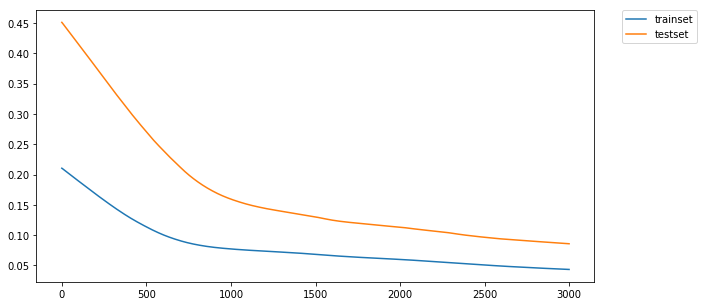

In [39]:
losses = score.history['loss']
val_losses = score.history['val_loss']
plt.figure(figsize=(10,5))
plt.plot(losses, label="trainset")
plt.plot(val_losses, label="testset")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

### Predictions for Test Data

#### Predicting for Test Data

In [40]:
df_result = pd.DataFrame({'Actual' : [], 'Prediction' : []})

for i in range(len(generator_test)):
    x, y = generator_test[i]
    x_input = array(x).reshape((1, n_input, n_features))
    yhat = model.predict(x_input, verbose=2)
    df_result = df_result.append({'Actual': scaler.inverse_transform(y)[0][0], 'Prediction': scaler.inverse_transform(yhat)[0][0]}, ignore_index=True)

#### Tabulating Actuals, Predictions and Differences

In [41]:
df_result['Diff'] = 100 * (df_result['Prediction'] - df_result['Actual']) / df_result['Actual']

In [42]:
df_result

,Actual,Prediction,Diff
0,7572.0,2957.357422,-60.943510
1,7328.0,4578.464355,-37.520956
2,8156.0,5811.522461,-28.745433
3,7965.0,4169.111816,-47.657102
4,3510.0,4400.051758,25.357600
5,5478.0,2878.707275,-47.449666
6,6392.0,2820.102051,-55.880756
7,7691.0,4382.410156,-43.018981
8,7570.0,6410.245605,-15.320402
9,7282.0,4843.450195,-33.487363


#### Calculating the Correctness for Test Data

In [43]:
mean = df_result['Actual'].mean()
mae = (df_result['Actual'] - df_result['Prediction']).abs().mean()

print("mean: ", mean)
print("mae:", mae)
print("mae/mean ratio: ", 100*mae/mean,"%")
print("correctness: ", 100 - 100*mae/mean,"%")

mean:  6547.175
mae: 2119.0196166992187
mae/mean ratio:  32.36540365423589 %
correctness:  67.63459634576411 %


#### Plot of Actuals and Predictions for Test Data

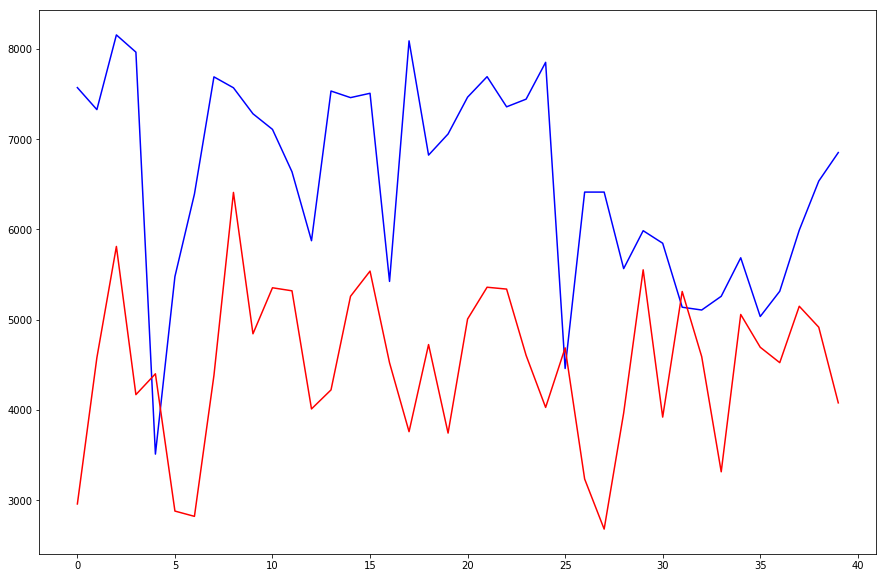

In [44]:
plt.figure(figsize=(15,10))
plt.plot(df_result['Actual'], color='blue')
plt.plot(df_result['Prediction'], color='red')
plt.show()

### Predictions for Hold-Out Data

#### Predicting for Hold-Out Data

In [45]:
df_result = pd.DataFrame({'Actual' : [], 'Prediction' : []})

for i in range(len(generator_hold)):
    x, y = generator_hold[i]
    x_input = array(x).reshape((1, n_input, n_features))
    yhat = model.predict(x_input, verbose=2)
    df_result = df_result.append({'Actual': scaler.inverse_transform(y)[0][0], 'Prediction': scaler.inverse_transform(yhat)[0][0]}, ignore_index=True)

#### Tabulating Actuals, Predictions and Differences for Hold-Out Data

In [46]:
df_result['Diff'] = 100 * (df_result['Prediction'] - df_result['Actual']) / df_result['Actual']

In [47]:
df_result

,Actual,Prediction,Diff
0,2425.0,5392.068848,122.353355
1,3910.0,3407.168213,-12.860148
2,2277.0,4113.768066,80.666143
3,2424.0,4091.925293,68.808799
4,5087.0,2917.213867,-42.653551
5,3959.0,4984.996094,25.915537
6,5260.0,3951.427490,-24.877804
7,5323.0,4989.065430,-6.273428
8,5668.0,5247.795898,-7.413622
9,5191.0,4748.819824,-8.518208


#### Calculating the Correctness for Hold-Out Data

In [48]:
mean = df_result['Actual'].mean()
mae = (df_result['Actual'] - df_result['Prediction']).abs().mean()

print("mean: ", mean)
print("mae:", mae)
print("mae/mean ratio: ", 100*mae/mean,"%")
print("correctness: ", 100 - 100*mae/mean,"%")

mean:  4001.15
mae: 1302.6686279296875
mae/mean ratio:  32.55735545854785 %
correctness:  67.44264454145215 %


#### Plot of Actuals and Predictions for Hold-Out Data

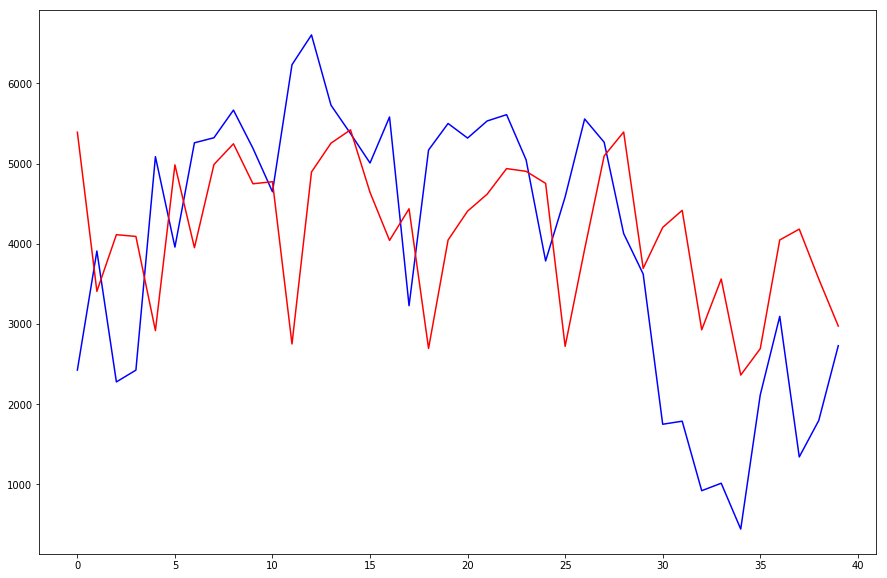

In [49]:
plt.figure(figsize=(15,10))
plt.plot(df_result['Actual'], color='blue')
plt.plot(df_result['Prediction'], color='red')
plt.show()